# Research Findings on OpenCV for Manufactuing Object Classification

## Problem Statement

In manufacturing it is costly, time consuming and hard to maintain full scale MES(Manufacturing Execution system deployments to track production. The problem is magnified when looking at the multitude of suppliers needed for a product in different locations. Most factories still use manual counting and Excel spreadsheets.

This solution aims to solve the problem by doing multi-class classification on images of products as they pass by on the production line. By correctly classifying the images an application using the model will be able to count the amount of products being manufactured across the entire supply chain.

## Features Importance / Descriptions

#### Features used in modeling consist of:
1. SIFT / SURF
2. Hue Histograms
3. Edge Histogram
4. Haar Features

Thus far, SIFT/SURF features have been the best performers at 1400 images with 3 classes. The document will thus focus mainly on these.

#### Brief explanation of the the features:
When detecting features sift will
1. Detect keypoints in image (distinctive points such as corners).
2. Describe each region around a keypoint as a feature vector, using a descriptor

Note: Each descriptor is 128 byte vector storing histogram of gradients. 100 of these descriptors will be recorded per images

<img src="http://www.codeproject.com/KB/recipes/619039/SIFT.JPG"></img>

#### Visual Bag of Words
The same as in Natural Language Processing, each descriptor is added to a vocabulary.

For technical details see the following methods in classification.py
- createBOWVocab (Creates the vocabulary from training data)
- createMatcher (Matches image descriptors to the vocabulary)

SIFT/SURF was also selected due to scale and rotation invariance. This however comes at a cost. The model is un-aware of spatial relationships between features

<div style="float: left;"><img width="600" src="https://dl.dropboxusercontent.com/u/478318/Capstone/BOW.png"></img></div>

### Features at diffirent sizes

* When the image is at a very high resolution, many unnecessary edges are found
* When the image is resized, more of the important edges and features are found

As a conclusion, all images will be resized to a image with with 300px and height adjusted proportionally

In [2]:
from lib import imagetransform as it 
from lib import classification as c

import cv2, math, os, re, joblib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn import cross_validation, svm, metrics, ensemble, linear_model, neighbors, tree                                                  
%matplotlib inline

In [74]:
print cv2.__version__

3.1.0-dev


In [30]:
img_rem_large = cv2.imread('researchimages/remotelarge.jpg',0)
img_rem = cv2.imread('researchimages/remoteh.png', 0)

sift = cv2.xfeatures2d.SIFT_create()   
kp = sift.detect(img_rem_large, None)    

img_sift = cv2.drawKeypoints(img_rem_large, kp, np.array([]))
 
#cv2.drawKeypoints(img_rem_large, kp, img_sift) 

#### Large Image, notice all the colored dots which are all detected as edges

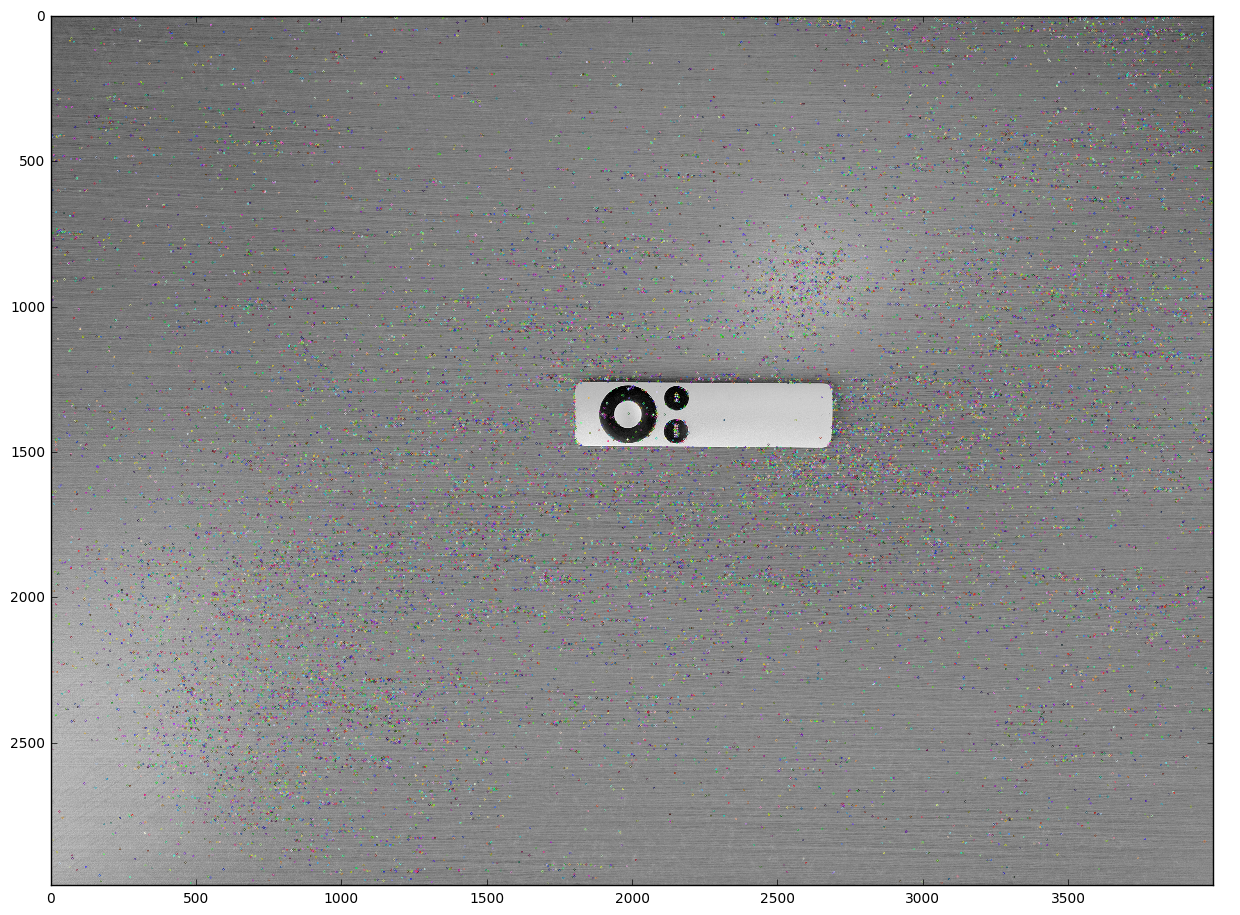

In [31]:
# Notice that image descriptors are everywhere on large 3000 by 4000 pixels
it.display(img_sift, imgisgray=False, fsize=(15,15), axis='on')

#### Now notice the smaller images and where the features are detected

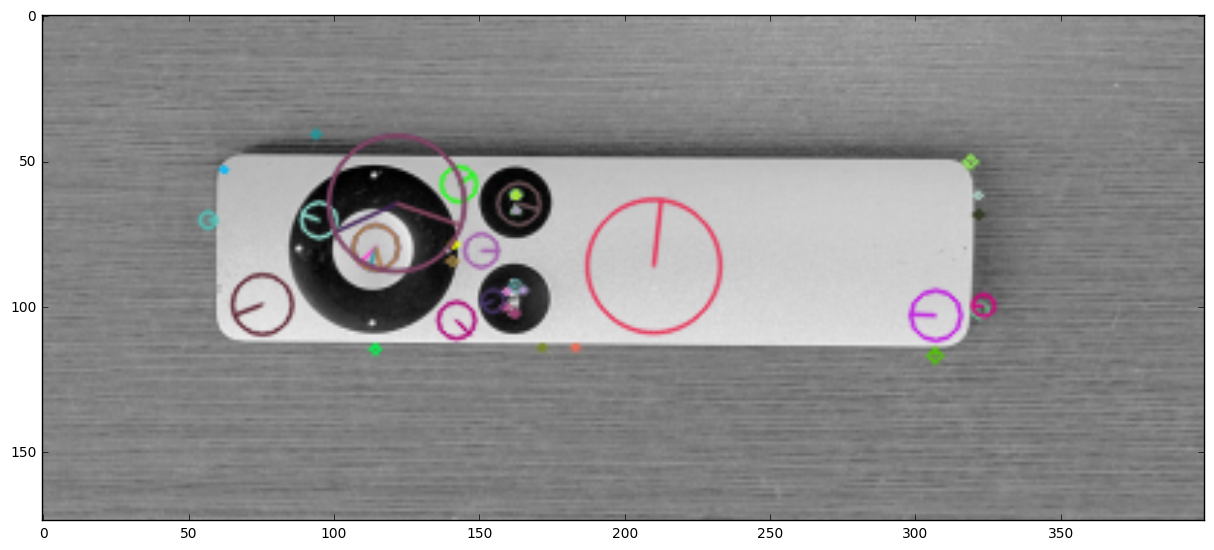

In [32]:
img_rem = it.resize(img_rem,400)
img_rem_large = it.resize(img_rem_large,300)

kp = sift.detect(img_rem, None)    

img_sift = cv2.drawKeypoints(img_rem, kp, np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
it.display(img_sift, imgisgray=False, fsize=(15,15), axis='on')

#### Using a different method of feature extraction with a smaller image size

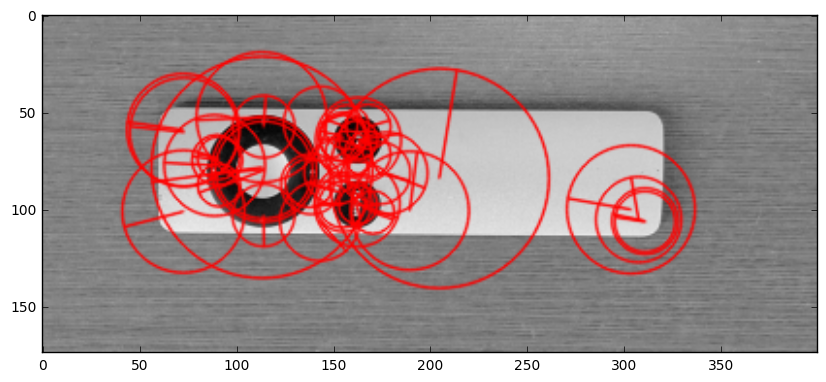

In [33]:
# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
surf = cv2.xfeatures2d.SURF_create(5000)

# Find keypoints and descriptors directly
kp, des = surf.detectAndCompute(img_rem,None)

img_surf = cv2.drawKeypoints(img_rem,kp,None,(0,0,255),4)
it.display(img_surf, imgisgray=False, axis='on')

### How does matching handle rotation
!!NOTE: if you want to run this code. Please run the matcher function at the bottom of the file first. It has been removed to keep the document more tidy

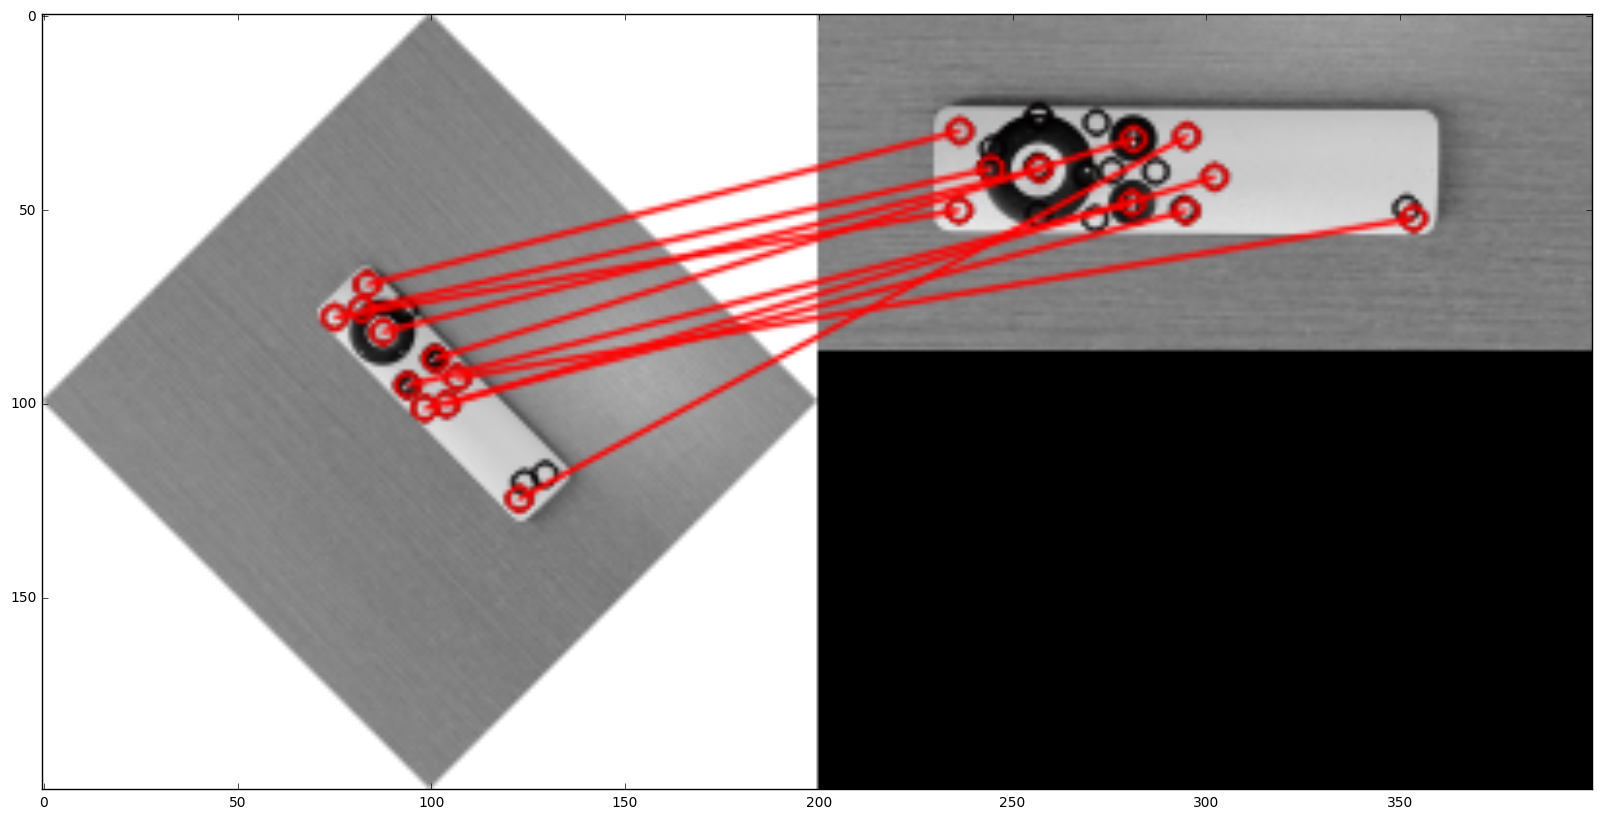

In [57]:
img_rotated = cv2.imread('researchimages/remoteskew2.png', 0)
img_rotated = it.resize(img_rotated,200)
surf.setExtended(True)
# get feature keypoints and descriptors
kp1, des1 = surf.detectAndCompute(img_rem,None)
kp2, des2 = surf.detectAndCompute(img_rotated,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# match descriptors.
matches = bf.match(des2,des1)
# sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# draw first 10 matches.

img3 = cv2.drawMatches(img_rotated,kp2,img_rem,kp1,matches[:10],np.array([]),(255,0,0),4)
fig = plt.figure(figsize=(20,20))
plt.imshow(img3)
plt.show()

### Image descriptors

In [58]:
#128 byte histograms of gradients
#Divide pixels into 16, 4X4 pixels squares
#Compute gradient direction histogram over 8 directions
#Concatenate the histograms to obtain a 128 (16*8) dimensional feature vector
len(des1[0])

128

In [59]:
des1[0]

array([ -1.43062067e-03,   1.70921173e-03,  -2.28998065e-03,
         2.29878561e-03,  -2.39122077e-03,   2.53977743e-03,
        -9.48171248e-04,   4.06006444e-03,  -9.47747566e-03,
         9.54715442e-03,   1.26265781e-02,   1.27358176e-02,
        -4.80824802e-03,   4.95942589e-03,   3.22257392e-02,
         3.23349759e-02,  -4.42998530e-03,   4.83956654e-03,
         1.40240285e-04,   1.93225540e-04,  -3.98238044e-05,
         4.76826943e-04,   1.02977818e-02,   1.03154434e-02,
         4.52378481e-06,   1.27050036e-04,  -9.46836826e-06,
         1.08185441e-05,   1.31097331e-04,   1.32447516e-04,
         7.23908579e-06,   6.80998273e-05,  -3.06142750e-03,
         9.40124411e-03,   2.74341926e-02,   4.10738625e-02,
        -7.16015650e-03,   3.56097743e-02,   2.04423006e-04,
         1.42228790e-02,   1.95817426e-01,   2.10285738e-01,
        -1.78451911e-01,   1.78451911e-01,   1.81740358e-01,
         1.81740358e-01,  -1.86581731e-01,   1.90632850e-01,
        -1.63459837e-01,

# Pipelines

Resize --> Remove RGB --> Remove Background --> Extract Contours --> Crop --> Match with BOW

#### Resize

All images are reduced proportionally with width of 600px. Images are resized to reduce insignificant edges from being detected like the cracks in the wood in the images above.

#### Extract image from background

Image segmentation is added to reduce background noise. For our problem we woul like the model to be able to accurately predict images in varios factories with minimal training.

1. Subtract image from a static background image. This is not a viable solution for the intended product. The conveyor can move and there will be many different backgrounds which would mean you would have to stabilize the camera each time and get a picture of the background which will be very impractical. 
2. Have a sequence of images and pass it though a background reduction 
3. Use a colored background and remove the color with a mask
4. Pass a video to a background algorithm

I used option 3 for training, and 4 for production

<div style="float: left;"><img src="https://dl.dropboxusercontent.com/u/478318/Capstone/ezgif.com-video-to-gif%20(1).gif"></img></div>
<div style="float: center;"><img src="https://dl.dropboxusercontent.com/u/478318/Capstone/ezgif.com-video-to-gif.gif"></img></div>

In the first image, the middle screen with the binary black and white image shows the MOG2 background reduction threshold.

#### Extract Contours & Crop
Once the image has been reduced to the white blob, we can detect the contours. On the second screen, notice the yellow box which is tracking the object as it moves. Once we have the contours we can extract just the image via cropping.

For the manufacturing application, tracking the object is also used as a trigger to classify and count the object. On the right hand gif, notice the yellow circle disappears when the object is detected

Note: Code for image separation, contour detection and cropping can be found in get_contours.py

<div style="float: left; padding-right: 1cm;">
<img width="600px" src="https://dl.dropboxusercontent.com/u/478318/Capstone/segmentation.png"></img>
</div>
#### Image 1
* A mask applied with an RGB filter for shades of red
* (BGR) lower, upper = [5, 5, 70], [150, 118, 250]
#### Image 2
* Inverstion of the mask (  255 - imagearray )


#### Image 3
* Original Image
#### Image 4
* Contours detected fromm inverted mask and drawn on image


#### Image 5
* Find all contours with area bigger than 100px 
* Add all contours x and y values together and calculate min and max
* Draw a box around for the x and y values
#### Image 6
* Crop image on min/max contour values

#### Remove RGB

All 3 color channels are removed. The SURF histogram of gradients are not dependent on color. 3 fold reduction in size. 

#### Extract features and match with BOW

Extract image edge points and descriptors. Compare their nearest neighbors in the vocabulary.
* The quantity of words significantly affects model accuracy however has a big penalty on speed

### Using the pipelines
Using the pipleline parameters in the code is as simple as passing paramters to the setClassifierParams funtion of our classification module. 

The code has to be called before using the classification module


In [2]:
from lib import classification
classification.setClassifierParams(crop=True,bow_size=400, hessian=400, grayscale=True, 
                                   verbose=False, resize=True, resize_width=600)

## Model Selection & Performance

### Summary

Models used were:
* LinearSVM
* Logistic
* Decision Tree
* KNN
* Random Forest
* SVM (kernel = rbf)

Different models did not affect scores more than a few percent. Therefore it was not found neccescary to try additional models. SVM based on popular belief has also been found to work the best with visual BOW which I found to be true while testing.

In [7]:
# Specify models to try
sup_vect = svm.LinearSVC(class_weight='balanced')
logreg = linear_model.LogisticRegression(class_weight='balanced')
knn = neighbors.KNeighborsClassifier()
dec_tree = tree.DecisionTreeClassifier(class_weight='balanced')
forest = ensemble.RandomForestClassifier(class_weight='balanced')
nu_svc = svm.NuSVC(kernel="rbf",class_weight='balanced')

models = [sup_vect, logreg, nu_svc, forest, dec_tree, knn]
models2 = ['Support Vector','Logistic Regression','Support Vector RBF','Random Forest', 'Decision Tree', 'K Nearest Neighbor']

# Quick funtion to give Luiz and Weekian less gr
def getScores(path):
    c.TRAIN_PATH = c.path_prefix + path
    train_data = c.getTrainData(True) #True = rebuild to model, dont get from Pkl

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    train_data[0], train_data[1], test_size=0.2)
    
    print "             precision    recall  f1-score   support"
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cr = metrics.classification_report(y_true=y_test, y_pred=y_pred)
        print re.split('\n', cr)[-2], models2[i]
    

## Lets see how ony 2 images per class perform train and test (5 Classes)

In [8]:
# Set Model Params -- Use 600 image resize here, test images = 600w, train = 1280w
c.setClassifierParams(crop=False,bow_size=700, hessian=400,grayscale=False,verbose=False, resize=True, resize_width=600)
c.TRAIN_PATH = c.path_prefix + 'dataset/imagesets/600w_5sets_red_only2/train/'
c.TEST_PATH = c.path_prefix + 'dataset/imagesets/600w_5sets_red_only2/test/'
train_data = c.getTrainData(True);
test_data = c.getTestData(True)

In [9]:
print "             precision    recall  f1-score   support"
for i, model in enumerate(models):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])
    cr = metrics.classification_report(y_true=train_data[1], y_pred=y_pred)
    print re.split('\n', cr)[-2], models2[i]

             precision    recall  f1-score   support
avg / total       0.67      0.80      0.72        10 Support Vector
avg / total       0.67      0.80      0.72        10 Logistic Regression
avg / total       0.26      0.40      0.29        10 Support Vector RBF
avg / total       0.17      0.30      0.20        10 Random Forest
avg / total       0.03      0.10      0.04        10 Decision Tree
avg / total       0.04      0.20      0.07        10 K Nearest Neighbor


## Lets see how performance is with 8 Train, 2 Test (5 Classes)

In [15]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True, verbose=False)

%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red_only10/train/')

             precision    recall  f1-score   support
avg / total       0.94      0.82      0.84        11 Support Vector
avg / total       0.03      0.18      0.06        11 Logistic Regression
avg / total       0.85      0.73      0.73        11 Support Vector RBF
avg / total       0.77      0.73      0.74        11 Random Forest
avg / total       0.52      0.36      0.41        11 Decision Tree
avg / total       0.56      0.36      0.35        11 K Nearest Neighbor
CPU times: user 17.8 s, sys: 148 ms, total: 18 s
Wall time: 3.26 s


## Now lets add some additional images.. about a 100 per class

In [10]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True, verbose=False)

%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.97      0.97      0.97       103 Support Vector
avg / total       0.97      0.97      0.97       103 Logistic Regression
avg / total       0.95      0.94      0.94       103 Support Vector RBF
avg / total       0.91      0.90      0.90       103 Random Forest
avg / total       0.86      0.83      0.84       103 Decision Tree
avg / total       0.85      0.70      0.70       103 K Nearest Neighbor
CPU times: user 7min 16s, sys: 432 ms, total: 7min 17s
Wall time: 1min 2s


## 5's not enough, lets go up to 10

In [28]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True,verbose=False)

%time getScores(train_data[0], train_data[1], 'dataset/imagesets/1280w_10sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.98      0.98      0.98       212 Support Vector
avg / total       0.91      0.88      0.86       212 Logistic Regression
avg / total       0.97      0.97      0.97       212 Support Vector RBF
avg / total       0.95      0.95      0.95       212 Random Forest
avg / total       0.92      0.91      0.91       212 Decision Tree
avg / total       0.93      0.91      0.91       212 K Nearest Neighbor
CPU times: user 54min 16s, sys: 10.5 s, total: 54min 27s
Wall time: 7min 46s


# Feature / Pipleline Settings

## Image Size

In [16]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=250)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.94      0.93      0.93       103 Support Vector
avg / total       0.94      0.93      0.93       103 Logistic Regression
avg / total       0.91      0.90      0.90       103 Support Vector RBF
avg / total       0.90      0.89      0.89       103 Random Forest
avg / total       0.76      0.73      0.73       103 Decision Tree
avg / total       0.83      0.74      0.74       103 K Nearest Neighbor
CPU times: user 45.3 s, sys: 252 ms, total: 45.5 s
Wall time: 9.85 s


In [17]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.97      0.97      0.97       103 Support Vector
avg / total       0.96      0.96      0.96       103 Logistic Regression
avg / total       0.93      0.92      0.92       103 Support Vector RBF
avg / total       0.86      0.85      0.85       103 Random Forest
avg / total       0.81      0.76      0.76       103 Decision Tree
avg / total       0.89      0.73      0.75       103 K Nearest Neighbor
CPU times: user 1min 13s, sys: 224 ms, total: 1min 13s
Wall time: 13.2 s


In [18]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=400)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.99      0.99      0.99       103 Support Vector
avg / total       0.98      0.98      0.98       103 Logistic Regression
avg / total       0.96      0.96      0.96       103 Support Vector RBF
avg / total       0.90      0.89      0.89       103 Random Forest
avg / total       0.82      0.79      0.79       103 Decision Tree
avg / total       0.86      0.76      0.75       103 K Nearest Neighbor
CPU times: user 2min 52s, sys: 288 ms, total: 2min 52s
Wall time: 27.6 s


In [19]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=600)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       1.00      1.00      1.00       103 Support Vector
avg / total       0.99      0.99      0.99       103 Logistic Regression
avg / total       0.96      0.96      0.96       103 Support Vector RBF
avg / total       0.93      0.92      0.92       103 Random Forest
avg / total       0.87      0.83      0.83       103 Decision Tree
avg / total       0.86      0.72      0.71       103 K Nearest Neighbor
CPU times: user 8min 3s, sys: 396 ms, total: 8min 4s
Wall time: 1min 9s


## Bag Of Word Sizes
Note: Baseline for 300px which we use for testing below has score of 0.95 recall and precision

In [20]:
c.setClassifierParams(crop=False,bow_size=50, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.90      0.90      0.90       103 Support Vector
avg / total       0.88      0.87      0.87       103 Logistic Regression
avg / total       0.93      0.92      0.92       103 Support Vector RBF
avg / total       0.95      0.95      0.95       103 Random Forest
avg / total       0.75      0.74      0.74       103 Decision Tree
avg / total       0.90      0.86      0.87       103 K Nearest Neighbor
CPU times: user 33.9 s, sys: 240 ms, total: 34.1 s
Wall time: 7.73 s


In [21]:
c.setClassifierParams(crop=False,bow_size=100, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.95      0.95      0.95       103 Support Vector
avg / total       0.93      0.93      0.93       103 Logistic Regression
avg / total       0.94      0.94      0.94       103 Support Vector RBF
avg / total       0.87      0.85      0.85       103 Random Forest
avg / total       0.79      0.79      0.79       103 Decision Tree
avg / total       0.88      0.87      0.87       103 K Nearest Neighbor
CPU times: user 45.5 s, sys: 164 ms, total: 45.7 s
Wall time: 9.32 s


In [22]:
c.setClassifierParams(crop=False,bow_size=200, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.97      0.97      0.97       103 Support Vector
avg / total       0.98      0.98      0.98       103 Logistic Regression
avg / total       0.97      0.97      0.97       103 Support Vector RBF
avg / total       0.93      0.92      0.92       103 Random Forest
avg / total       0.79      0.77      0.77       103 Decision Tree
avg / total       0.88      0.80      0.79       103 K Nearest Neighbor
CPU times: user 57.8 s, sys: 224 ms, total: 58 s
Wall time: 11.2 s


In [23]:
c.setClassifierParams(crop=False,bow_size=400, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.98      0.98      0.98       103 Support Vector
avg / total       0.95      0.95      0.95       103 Logistic Regression
avg / total       0.95      0.95      0.95       103 Support Vector RBF
avg / total       0.95      0.94      0.94       103 Random Forest
avg / total       0.84      0.83      0.83       103 Decision Tree
avg / total       0.87      0.65      0.66       103 K Nearest Neighbor
CPU times: user 1min 17s, sys: 248 ms, total: 1min 18s
Wall time: 14.2 s


In [24]:
c.setClassifierParams(crop=False,bow_size=600, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       1.00      1.00      1.00       103 Support Vector
avg / total       1.00      1.00      1.00       103 Logistic Regression
avg / total       0.98      0.98      0.98       103 Support Vector RBF
avg / total       0.95      0.94      0.94       103 Random Forest
avg / total       0.86      0.81      0.81       103 Decision Tree
avg / total       0.77      0.62      0.59       103 K Nearest Neighbor
CPU times: user 1min 26s, sys: 280 ms, total: 1min 26s
Wall time: 15.3 s


In [25]:
c.setClassifierParams(crop=False,bow_size=1000, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.97      0.97      0.97       103 Support Vector
avg / total       0.96      0.96      0.96       103 Logistic Regression
avg / total       0.91      0.84      0.85       103 Support Vector RBF
avg / total       0.90      0.88      0.88       103 Random Forest
avg / total       0.86      0.85      0.85       103 Decision Tree
avg / total       0.84      0.45      0.44       103 K Nearest Neighbor
CPU times: user 1min 57s, sys: 316 ms, total: 1min 58s
Wall time: 20 s


In [26]:
c.setClassifierParams(crop=False,bow_size=2000, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores(train_data[0], train_data[1], 'dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       1.00      1.00      1.00       103 Support Vector
avg / total       0.99      0.99      0.99       103 Logistic Regression
avg / total       0.94      0.92      0.93       103 Support Vector RBF
avg / total       0.90      0.86      0.86       103 Random Forest
avg / total       0.77      0.68      0.69       103 Decision Tree
avg / total       0.66      0.30      0.26       103 K Nearest Neighbor
CPU times: user 2min 41s, sys: 432 ms, total: 2min 42s
Wall time: 28.9 s


## Feature Importances

In [29]:
c.TRAIN_PATH = c.path_prefix + 'dataset/imagesets/600w_5sets_red/train/'
train_data = c.getTrainData(False) #True = rebuild to model, dont get from Pkl

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
train_data[0], train_data[1], test_size=0.2)

# Estimate the score on the entire dataset, with no missing valules
frst = ensemble.RandomForestClassifier(random_state=0, n_estimators=100, class_weight='balanced')
frst.fit(X_train, y_train)

#Perform classification on train test split
y_pred = frst.predict(X_test)
forest = frst
X = np.array(X_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 183 (0.029403)
2. feature 3 (0.024149)
3. feature 50 (0.019286)
4. feature 94 (0.018942)
5. feature 89 (0.016156)
6. feature 314 (0.014814)
7. feature 187 (0.013803)
8. feature 203 (0.013757)
9. feature 301 (0.013184)
10. feature 357 (0.013075)
11. feature 332 (0.012817)
12. feature 321 (0.011688)
13. feature 76 (0.011649)
14. feature 121 (0.010988)
15. feature 336 (0.010903)
16. feature 243 (0.010759)
17. feature 254 (0.010230)
18. feature 55 (0.010066)
19. feature 122 (0.009622)
20. feature 384 (0.009119)
21. feature 166 (0.008866)
22. feature 356 (0.008603)
23. feature 33 (0.008360)
24. feature 241 (0.008273)
25. feature 318 (0.008176)
26. feature 214 (0.007883)
27. feature 281 (0.007783)
28. feature 260 (0.007610)
29. feature 0 (0.007393)
30. feature 375 (0.007380)
31. feature 379 (0.007334)
32. feature 193 (0.007162)
33. feature 75 (0.006978)
34. feature 291 (0.006833)
35. feature 23 (0.006786)
36. feature 212 (0.006420)
37. feature 127 (0.006242)
38. f

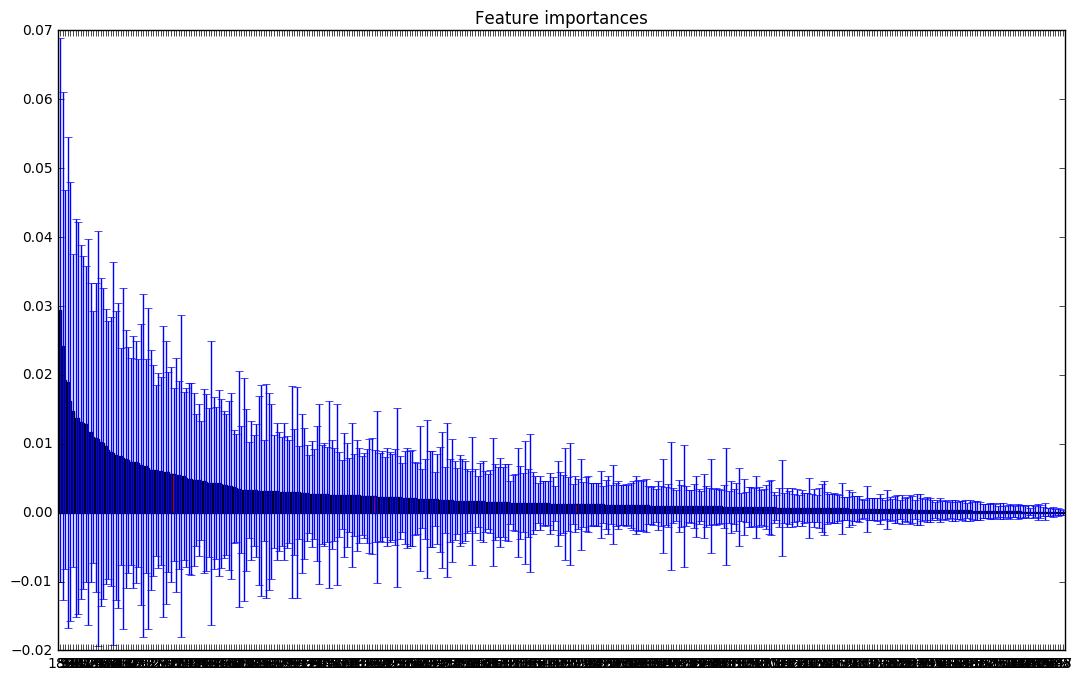

In [30]:
# Plot the feature importances of the forest
plt.figure(figsize=(13,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Best perorming parameters for 5 and 10 classes (Speed vs Performance)

In [8]:
c.setClassifierParams(crop=False,bow_size=600, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores('dataset/imagesets/600w_5sets_red/train/')

             precision    recall  f1-score   support
avg / total       0.98      0.98      0.98       103 Support Vector
avg / total       0.97      0.97      0.97       103 Logistic Regression
avg / total       0.97      0.97      0.97       103 Support Vector RBF
avg / total       0.91      0.89      0.90       103 Random Forest
avg / total       0.77      0.77      0.77       103 Decision Tree
avg / total       0.81      0.58      0.57       103 K Nearest Neighbor
CPU times: user 1min 25s, sys: 500 ms, total: 1min 26s
Wall time: 15.5 s


In [16]:
c.setClassifierParams(crop=False,bow_size=600, hessian=400,grayscale=True,verbose=False,
                      resize=True, resize_width=300)
%time getScores('dataset/imagesets/1280w_10sets_red/train/')

             precision    recall  f1-score   support
avg / total       1.00      1.00      1.00       212 Support Vector
avg / total       0.99      0.99      0.99       212 Logistic Regression
avg / total       0.99      0.99      0.99       212 Support Vector RBF
avg / total       0.97      0.97      0.97       212 Random Forest
avg / total       0.90      0.90      0.90       212 Decision Tree
avg / total       0.93      0.90      0.89       212 K Nearest Neighbor
CPU times: user 6min 12s, sys: 620 ms, total: 6min 13s
Wall time: 1min 11s


# Findings Summary


* Finding the right features  has a much bigger impact on performance than tweaking model parameters. Surf has far outperformed HueHistograms and Histogram of Gradients due to its scale and rotation invariance.
 * Bage of word size and image size have the biggest impact on model prediction and performance.
 * in the Feature importance graph above, even though the feature importances vastely reduce at about a third of the words, the cumulative sum of the remaining words still make a significant difference.
 * Theree ssems to be a great balance of size vs performace at IMG size 300 (Gray) with words of around 600.
* Cropping has not added any benifit when the background train and test are consistant, however when the test backgrounds are differnt it adds significant benifit. (This has been tested in the demo application which will be part of the final presentation)
* For this classification problem SVM has outperformed all other classifiers tested. Especially with lower quantity of samples. Other models improve as you add more samples. Logistic being a close second.



# Stake Holder Reccomendation & Next Steps

* Adding another 10, 20 classes to further analyse performance
* Get a 1080 fast focusing c.amera I had have used 2 cameras thus far and the performance increase from Logitek c310 to 525 was roughly 8%
* Store the images in the ideal format, i.e. gray scale, size 300 px, cropped instead of doing convestions each time the model is generated.
* Introduce the ability to acurately predict that a new image is "not" part of any of the existing classes. For the intended manufacturing application this will be usefull to have a very low user input system.


## Source Code

There are 4 main modules in the Lib folder provided

classification.py
get_contour.py
auto_thresh.py

* The classification module is used for all the classification and feauture pipline tasks.
* The get_contour will be renamed, but was used to generate train data. This will also be the final demo application to show the potential manufacturing application.
* The auto_thresh is responsible for the image segmentation, and performs the cropping 





